In [6]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from glob import glob
from uuid import uuid4
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
startech_df = pd.concat(
    [pd.read_excel(path) for path in glob("./datasets/scrapped_data/*")]
)
print(startech_df.shape)
startech_df = startech_df.dropna().reset_index(drop=True).copy()
startech_df["id"] = [str(uuid4()) for _ in range(startech_df.shape[0])]
startech_df = startech_df[["id", "name", "price", "category", "specification"]]
print(startech_df.shape)
startech_df.head(5)

(7913, 4)
(6334, 5)


,id,name,price,category,specification
0,f13675a6-8502-410b-80dd-f591ff1bedc8,AMD Ryzen 5 5600G Budget Desktop PC,26699,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
1,959a8c24-ead8-46d5-9934-09602ee708e2,AMD Ryzen 5 5600G Desktop PC,29500,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
2,7f6d2a8f-c6ef-4207-b817-c4e0c3df93a0,Intel 12th Gen Core i5-12400 Desktop PC,31200,Star PC,Processor: Intel 12th Gen Core i5-12400 Alder ...
3,b9d5b6f7-d8f1-4262-a1fe-f787fd37f631,AMD Ryzen 7 5700G Custom Desktop PC,32400,Star PC,Processor: AMD Ryzen 7 5700G Processor with Ra...
4,58528ec5-3165-460e-a6b9-a50a31207c7b,AMD Ryzen 5 8500G Desktop PC,37499,Star PC,Processor: AMD Ryzen 5 8500G Processor with Ra...


In [ ]:
startech_df_first_half = (
    startech_df.iloc[0 : startech_df.shape[0] // 2].reset_index(drop=True).copy()
)
startech_df_last_half = (
    startech_df.iloc[startech_df.shape[0] // 2 :].reset_index(drop=True).copy()
)

startech_df.to_excel("./datasets/startech.xlsx", index=False, engine="xlsxwriter")
startech_df_first_half.to_excel(
    "./startech_first_half.xlsx", index=False, engine="xlsxwriter"
)
startech_df_last_half.to_excel(
    "./startech_last_half.xlsx", index=False, engine="xlsxwriter"
)

## Join generated queries dataframe with main dataset


In [2]:
def format_product_details(name, price, specification):
    product_details = ""
    if specification is not None:
        product_details = f"Name: {name}\nPrice: {price} taka\n{specification.strip()}"
    else:
        product_details = f"Name: {name}\nPrice: {price} taka"

    return product_details

In [3]:
query_df = [pd.read_excel(path) for path in glob("./datasets/generated_data/english/*.xlsx")]
query_df.extend([pd.read_excel(path) for path in glob("./datasets/generated_data/bengali/*.xlsx")])

query_df = pd.concat(query_df)
print(query_df.shape)
query_df.sample(10).head(10)

(89078, 2)


,id,relevant_query
3038,f5037a8f-1eda-4429-a93c-e07222284392,অটোফোকাস সহ ওয়েবক্যাম
11503,15bf22ef-9c2e-4366-abff-b1a27b20be97,কম দামের ওয়াইফাই রাউটার
7356,61ec2106-67cf-4a89-9d4c-ac79f4f59668,আটটি এক্সপেনশন স্লট যুক্ত কেস
17493,b5ab9a18-2576-4a63-ad29-0cb7fa0eb82d,ব্যাটারি অদলন
1864,462d9609-6e38-45c5-a5a6-76f694996a4e,Beko 8kg top loader washing machine
33275,788104c7-e131-4ac0-a9b8-d3cdf564f8f7,Sharp R-2235H দিয়ে খাবার গরম করা
386,2b4ff884-c32a-4fa5-938d-705a1936e274,Samsung CU8100 75 inch TV
11962,788bb007-38c0-4a2d-a82c-6223080425a1,কম্পিউটার নেটওয়ার্কিং এর জন্য রাউটার
18173,6647b004-fc7a-4ea2-9969-1e50edafbf32,ব্যাটারি পরিবর্তন করে কিভাবে
1031,9dde32fb-19ac-445d-9855-46bed8047c0f,long lasting battery smartphone


In [4]:
product_df = pd.read_excel("./datasets/startech.xlsx")
print(product_df.shape)
product_df.head(5)

(6334, 5)


,id,name,price,category,specification
0,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,AMD Ryzen 5 5600G Budget Desktop PC,26699,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
1,34c772a6-ef7d-4f3c-ae95-3c8acff1a1b4,AMD Ryzen 5 5600G Desktop PC,29500,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
2,e3c3d67a-5138-481b-930c-dcb64ea67b93,Intel 12th Gen Core i5-12400 Desktop PC,31200,Star PC,Processor: Intel 12th Gen Core i5-12400 Alder ...
3,797a3b0a-8c2b-4cf6-8a90-2f36a82bd722,AMD Ryzen 7 5700G Custom Desktop PC,32400,Star PC,Processor: AMD Ryzen 7 5700G Processor with Ra...
4,71be6c35-b744-4b69-8f1b-ee665c29a76a,AMD Ryzen 5 8500G Desktop PC,37499,Star PC,Processor: AMD Ryzen 5 8500G Processor with Ra...


## Adding category to query dataframe


In [5]:
query_df = query_df.merge(product_df[["id", "category"]], on="id", how="left").copy()
print(query_df.shape)
query_df.tail(10)

(89078, 3)


,id,relevant_query,category
89068,56c303df-c2f8-4121-a7be-c4eacff2069e,পেশাদার কাপড় গরম করার যন্ত্র,Iron
89069,56c303df-c2f8-4121-a7be-c4eacff2069e,Panasonic NI-GSE040PTH মডেলের কাপড় গরম করার যন...,Iron
89070,56c303df-c2f8-4121-a7be-c4eacff2069e,Panasonic NI-GSE040PTH দিয়ে সহজে কাপড় গরম করা ...,Iron
89071,a00a4134-03d9-462c-bd4e-c947f61cf40b,কাপড় পরিষ্কার করার যন্ত্র,Iron
89072,a00a4134-03d9-462c-bd4e-c947f61cf40b,স্টিম দিয়ে কাপড় ফর্সা করার মেশিন,Iron
89073,a00a4134-03d9-462c-bd4e-c947f61cf40b,গাড়ামালির জন্য বাষ্পীভবনকারী,Iron
89074,a00a4134-03d9-462c-bd4e-c947f61cf40b,নতুন কাপড় ভাঁজ করার সরঞ্জাম,Iron
89075,a00a4134-03d9-462c-bd4e-c947f61cf40b,গাড়ামালির জন্য বাষ্পীভবনকারী,Iron
89076,a00a4134-03d9-462c-bd4e-c947f61cf40b,Panasonic NI-GSE050ATH মডেলের স্টিমার,Iron
89077,a00a4134-03d9-462c-bd4e-c947f61cf40b,Panasonic গাড়ামালির জন্য স্টিমার,Iron


In [7]:
bangla_chars = 'অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢণতথদধনপফবভমযরলশষসহড়ঢ়য়ৎঁংঃািীুূৃেৈোৌ্'
english_chars = 'abcdefghijklmnopqrstuvwxyz'

def is_bangla_word(word):
    return any(char in bangla_chars for char in word)

def add_en_bn_typo(word):

    # mitake injection algo 
    if len(word) < 5: #  can be 4
        return word  # too short to apply typo to
    
    is_word_bn = is_bangla_word(word) 
    
    # randomly select an index for the word
    idx = random.randint(0, len(word) - 2) #  len(word) - 1, then word[idx+1] will throw idx error 
    typo_type = random.choice(['swap', 'delete', 'insert', 'substitute']) # 4 types of typing mistake 
    if typo_type == 'swap':
        return word[:idx] + word[idx+1] + word[idx] + word[idx+2:]
    elif typo_type == 'delete':
        return word[:idx] + word[idx+2:] # misses 2 letters
    elif typo_type == 'insert':
        return word[:idx] + random.choice(bangla_chars if is_word_bn else english_chars) + word[idx:]
    elif typo_type == 'substitute':
        return word[:idx] + random.choice(bangla_chars if is_word_bn else english_chars) + word[idx+1:]
    return word

def inject_en_bn_noise(query):
    return ' '.join(add_en_bn_typo(word) for word in query.split())

## For every product of a category, take positive query from other categories


In [23]:
category_list = list(product_df["category"].unique())
print(f"Num categories: {len(category_list)}")

train_dict = {"category": [], "anchor": [], "positive": [], "negative": []}

for idx, row in tqdm(product_df.iterrows(), total=product_df.shape[0]):
    id = row["id"]
    name = row["name"]
    price = row["price"]
    specification = row["specification"]
    category = row["category"]

    anchor = format_product_details(name, price, specification)

    positive_queries = query_df[query_df["id"] == id]["relevant_query"].tolist() + [name]
    num_positive_queries = len(positive_queries)

    random_categories = np.random.choice(
        product_df[product_df["category"] != category]["category"].unique().tolist(),
        num_positive_queries,
        replace=False,
    )
    
    negative_queries = []
    for random_category in random_categories:
        random_query = np.random.choice(
            list(query_df[query_df["category"] == random_category]["relevant_query"]),
            1,
            replace=False,
        )[0]
        negative_queries.append(str(random_query))

    
    
    train_dict["positive"].extend(positive_queries)
    train_dict["negative"].extend(negative_queries)

    typo_pos_q = [inject_en_bn_noise(pos_q) for pos_q in positive_queries]
    train_dict["positive"].extend(typo_pos_q)
    
    typo_neg_q = [inject_en_bn_noise(neg_q) for neg_q in negative_queries]    
    train_dict["negative"].extend(typo_neg_q)

    train_dict["category"].extend([category] * (num_positive_queries * 2))
    train_dict["anchor"].extend([anchor] * (num_positive_queries * 2))


Num categories: 166


  0%|          | 0/6334 [00:00<?, ?it/s]

In [24]:
all_data = pd.DataFrame.from_dict(train_dict)
all_data.sample(10).head(10)

,category,anchor,positive,negative
175140,Power Bank,Name: Joyroom JR-L012 10000mah 22.5W Fast Char...,Joygoom -L012 দিয়ে দ্রতু চাজ,wasng machfine for larage loasd
57807,Projector,Name: ViewSonic PA503SE 4000 Lumens SVGA Busin...,Vieonic PA5m03SE 4000 Lumegns SVGA Busess Proj...,eontrol sveeral computrrs with one keybod
48249,Voltage Stabilizer,Name: Tecnoware 25KVA Electronic Three Phase S...,শিল্পের জন্য পাওয়ার সাপ্লাই,১U উচ্চতার তার ব্যবস্থাপনা
122252,Laptop Accessories,Name: MaxGreen C21N1638 Laptop Battery For Asu...,Acer,large capacity office scanner and copier
150447,Cable,Name: UGREEN US171 2m Rubber Shell Type-C to L...,while cpble for iPhyone chauging,সেরা মানরে 8K িডসপ্লে
155058,Microphone,Name: AKG P170 High-Performance Small Diaphrag...,profesisonal kocal miophone,qhermal bel rylls stikcer sheefts
13972,Motherboard,Name: GIGABYTE B650M H AM5 Micro-ATX Motherboa...,4096x2160 রেজোলিউশনের জন্য মাদারবোর্ড,7 বা তার বেশি বাটন গেমিং মাউস
50453,Phone,Name: Vivo V40 Lite\nPrice: 31899 taka\nSize: ...,Vivo V40 Lite,small form factor workstation
21924,Power Supply,Name: Gigabyte P450B 450W 80 Plus Bronze Certi...,Gigabyte P450B 450W PSU,high power laser presentation device
125099,Laptop Accessories,"Name: Laptop Battery for Asus UX300, UX3400, U...",ল্যাপের ব্যাটাঔরি পরিবরত্তন,eLxar JumpkDrive F35 64GB


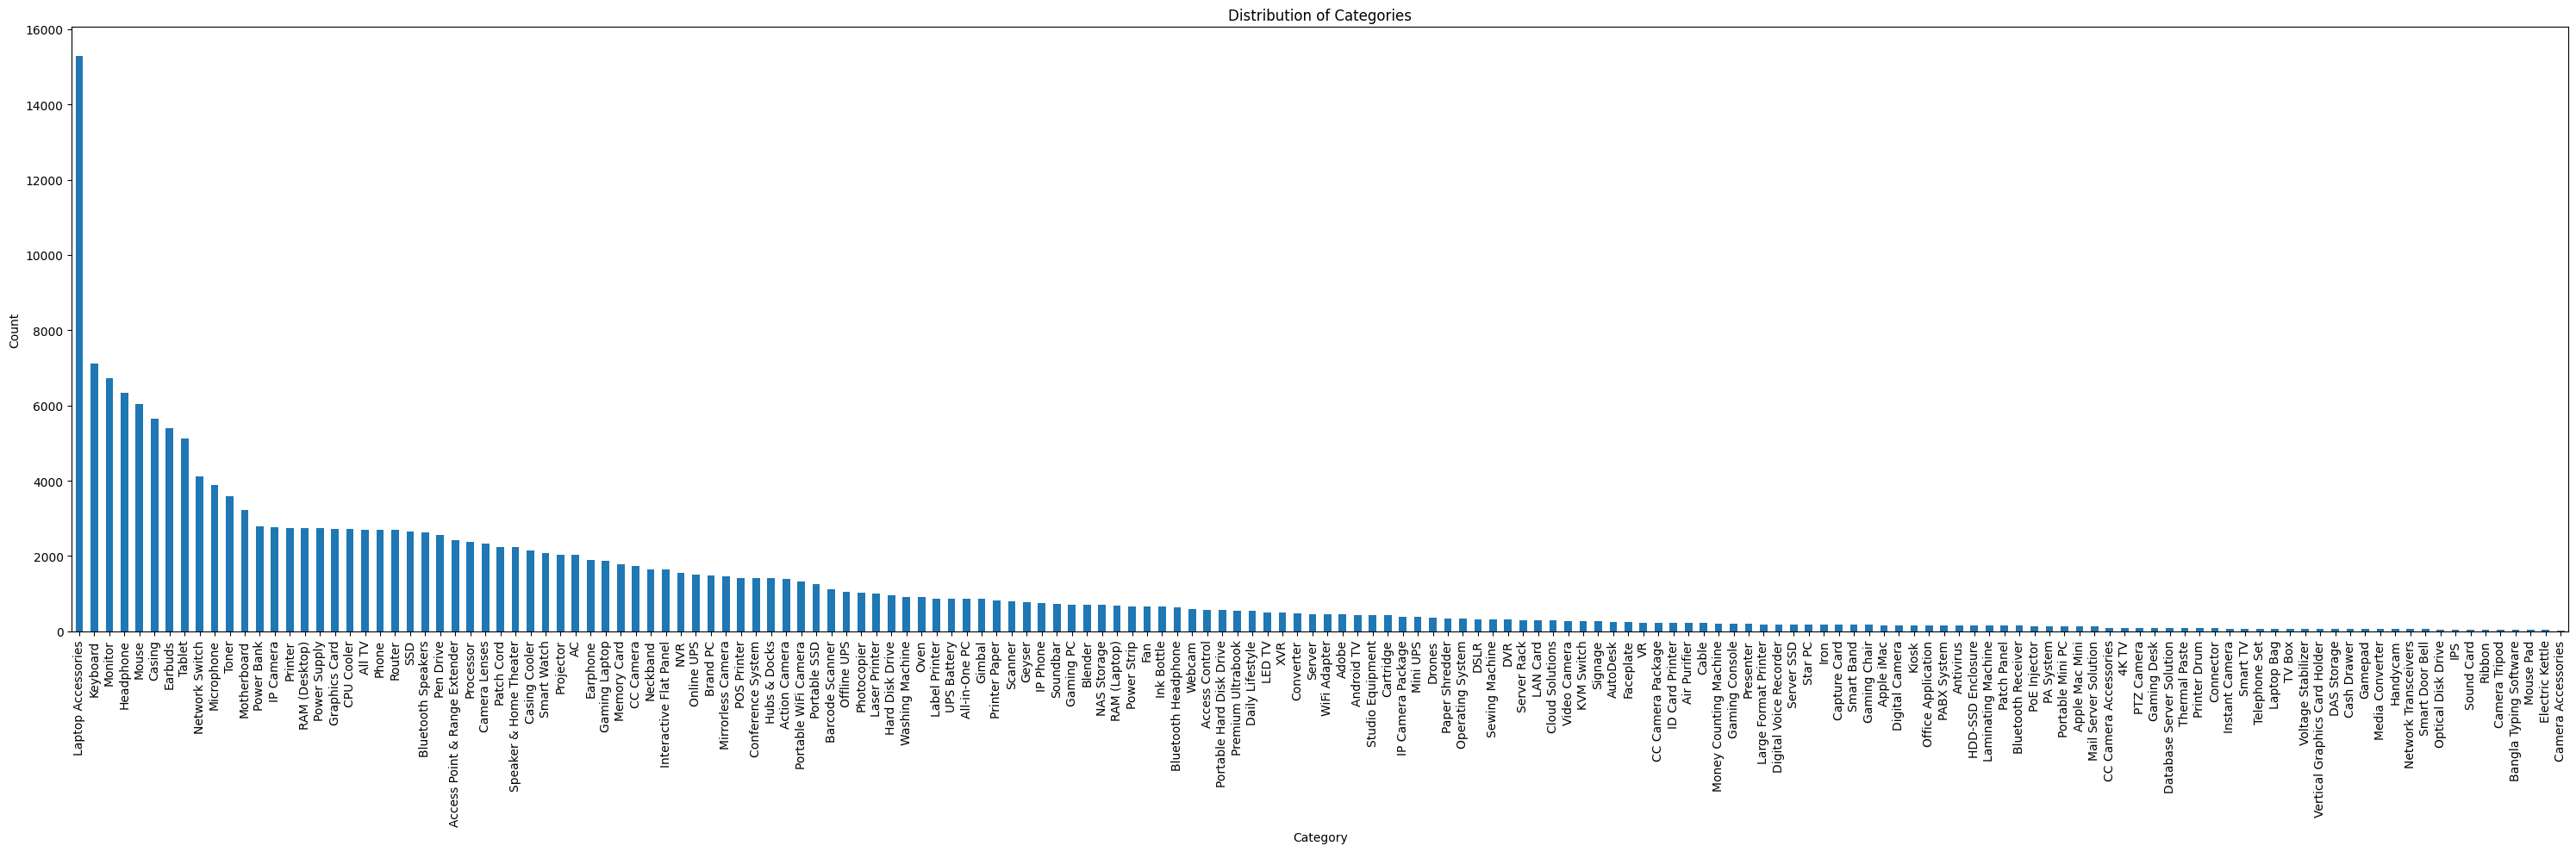

In [25]:
plt.figure(figsize=(30, 10))
all_data["category"].value_counts().plot(kind="bar")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.tight_layout()
plt.show()

## Dataset split


In [26]:
train_df, val_df = train_test_split(
    all_data,
    test_size=0.10,
    random_state=42,
    stratify=all_data["category"],
    shuffle=True,
)
train_df, test_df = train_test_split(
    train_df,
    test_size=0.20,
    random_state=42,
    stratify=train_df["category"],
    shuffle=True,
)

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

train_df.shape, val_df.shape, test_df.shape

((137392, 4), (19083, 4), (34349, 4))

In [27]:
train_df.to_csv("./datasets/train.csv", index=False)
test_df.to_csv("./datasets/test.csv", index=False)
val_df.to_csv("./datasets/val.csv", index=False)